In [58]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from skimage.io import imread
from torchinfo import summary
from tqdm import tqdm


### Build dataloader

In [70]:
class MyoDataSet(Dataset):
    def __init__(self, image_stack, len_in, normalization=1000):
        super().__init__()

        self.data = torch.tensor(image_stack/normalization)
        self.len_in = len_in

    def __len__(self):
        return len(self.data)-self.len_in+1

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        x = {'input': self.data[idx:idx+self.len_in], 
             'target': self.data[idx:idx+self.len_in]}
        
        return x

    def get_loader(self, indices, batch_size, num_workers, pin_memory=True):
        sampler = SubsetRandomSampler(indices)
        loader = torch.utils.data.DataLoader(self, 
            batch_size=batch_size,
            num_workers=num_workers, # number of cores to use, I usually just choose either 0 or 4
            sampler=sampler, 
            pin_memory=pin_memory) # pin memory should be true if you are transferring data between cpu and gpu
        return loader



TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


(41, 128, 128)


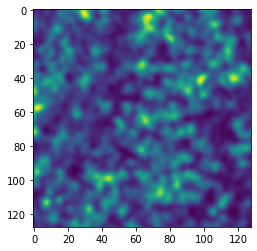

In [71]:
fpath = 'data/WT_cell1_cutout1.tif'
im1 = imread(fpath).astype('float32')
print(im1.shape)
plt.imshow(im1[0])

In [72]:
trainSet = MyoDataSet(im1, 1)
x = trainSet[40]
print(torch.max(x['input']))

tensor(2.1120)


In [73]:
loader = trainSet.get_loader(np.arange(len(trainSet)), 4, 0)
x = next(iter(loader))
print(len(loader))
#print(target.shape)

11


### Define convolutional autoencoder

In [86]:
class encoderNN(nn.Module):
    def __init__(self, input_size=(6, 128, 128), init_fmap=12, layers=3, downsample_factor=2, neck_dim=1000):
        super().__init__()

        in_channel, h, w = tuple(input_size)
        current_size = (h, w)

        # List of encoder layers
        encoderList = []
        current_fmaps = init_fmap
        for ii in range(layers):
            out_fmap = current_fmaps * downsample_factor
            encoderList += [nn.Conv2d(in_channel, current_fmaps, kernel_size=(3,3), padding=1),
                         #nn.BatchNorm2d(out_fmap),
                         nn.ReLU(),
                         nn.MaxPool2d((downsample_factor, downsample_factor))]
            in_channel = current_fmaps
            current_fmaps = current_fmaps * downsample_factor
            h = int(h/downsample_factor)
            w = int(w/downsample_factor)
        
        self.encoder = nn.Sequential(*encoderList)
        self.bottom_h = h
        self.bottom_w = w

        # List of bottleneck layers
        dense1 = in_channel*h*w
        neckList = [nn.Flatten(),
                    nn.Linear(dense1, neck_dim),
                    nn.ReLU(),
                    nn.Dropout()]

        self.bottleneck = nn.Sequential(*neckList)

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        return x

class interp(nn.Module):
    def __init__(self, size, mode='nearest-exact'):
        super().__init__()

        self.size = size
        self.mode = mode

    def forward(self, x):
        return nn.functional.interpolate(x, size = self.size, mode = self.mode)

class decoderNN(nn.Module):
    def __init__(self, neck_dim=1000, output_size=(6, 128, 128), final_fmap = 12, layers=3, upsample_factor=2):
        super().__init__()

        target_fmaps, h, w = tuple(output_size)
        self.bottom_h = int(h * upsample_factor**(-layers))
        self.bottom_w = int(w * upsample_factor**(-layers))
        self.in_channel = int(final_fmap * np.power(upsample_factor, layers-1))

        dense1 = self.in_channel * self.bottom_h * self.bottom_w

        self.upNeck = nn.Sequential(nn.Linear(neck_dim, dense1), nn.ReLU(), nn.Dropout())

        decoderList = []

        current_fmaps = self.in_channel       # Try interpolate+convolution instead of ConvTranspose2d to avoid checkerboard artifect?
        (h, w) = (self.bottom_h*upsample_factor, self.bottom_w*upsample_factor)
        for ii in range(layers-1):
            out_fmaps = int(current_fmaps / upsample_factor)
            decoderList += [interp((h, w), 'nearest-exact'), 
                            nn.Conv2d(current_fmaps, out_fmaps, kernel_size=(3,3), padding=1),#nn.ConvTranspose2d(current_fmaps, out_fmaps, kernel_size = upsample_factor, stride = upsample_factor),
                            nn.BatchNorm2d(out_fmaps),
                            nn.ReLU()]
            current_fmaps = out_fmaps
            (h, w) = (h*upsample_factor, w*upsample_factor)
         
        decoderList += [interp((h, w), 'nearest-exact'), nn.Conv2d(current_fmaps, target_fmaps, kernel_size=(3,3), padding=1)] #nn.ConvTranspose2d(current_fmaps, target_fmaps, kernel_size = upsample_factor, stride = upsample_factor)
                        #nn.BatchNorm2d(target_fmaps),
                        #nn.Sigmoid()]
                        
        self.decoder = nn.Sequential(*decoderList)

    def forward(self, x):
        x = self.upNeck(x)
        x = x.view(-1, self.in_channel, self.bottom_h, self.bottom_w)
        x = self.decoder(x)
        return x


class CAE(nn.Module):
    def __init__(self, input_size = (6, 128, 128), init_fmaps = 12, layers = 3, sample_factor = 2, neckdim = 1000):
        super().__init__()
        self.input_size = input_size
        self.init_fmaps = init_fmaps
        self.layers = layers
        self.sample_factor = sample_factor
        self.neckdim = neckdim

        self.encoding = encoderNN(self.input_size, self.init_fmaps, self.layers, self.sample_factor, self.neckdim)
        self.decoding = decoderNN(self.neckdim, self.input_size, self.init_fmaps, self.layers, self.sample_factor)
        
    def forward(self, x):
        encoded = self.encoding(x)
        decoded = self.decoding(encoded)
        return decoded

In [91]:
# Print model summary
input_size = (1, 128, 128)
init_fmaps = 6
layers = 3
sample_factor = 2
neckdim = 1000
model = CAE(input_size, init_fmaps, layers, sample_factor, neckdim)
#summary(model, input_size=(4, 1, 128, 128))       # Input size for torchinfo needs to have the size (B,C,H,W)

### Define model training/validation

In [92]:
## To do: move to device, log tensorboard, metric for validation? training rate scheduler?

def train(model, dataloader, lossfn, optimizer):     # Training step for each epoch
    model.train()

    totalLoss = 0
    optimizer.zero_grad()
    for minibatch in dataloader:
        y = model(minibatch['input'])
        loss = lossfn(y, minibatch['target'])
        loss.backward()
        optimizer.step()
        totalLoss += loss

    return totalLoss/len(dataloader)

def validate(model, dataloader, lossfn):      # Validate after each epoch, returns the loss 
    model.eval()

    x = next(iter(dataloader))
    y = model(x['input'])
    loss = lossfn(y, x['target'])

    return loss

loss = torch.nn.L1Loss()
optim = torch.optim.Adam(params = model.parameters(), lr = 1e-4)

numEpoch = 500
train_loss = np.zeros(numEpoch)
val_loss = np.zeros(numEpoch)
for ii in tqdm(range(numEpoch)):
    epochLoss = train(model, loader, loss, optim)
    validLoss = validate(model, loader, loss)
    train_loss[ii] = epochLoss
    val_loss[ii] = validLoss
    if ii%50==1:
        print("Epoch ", ii, "    Training loss: ", epochLoss.detach().cpu().numpy(), ", Validation loss: ", validLoss.detach().cpu().numpy())

torch.save(model.state_dict(), 'model0120_ld1000_L1.pt')
    

  0%|          | 2/500 [00:02<08:55,  1.08s/it]

Epoch  1     Training loss:  0.3702096 , Validation loss:  0.4643855


 10%|█         | 52/500 [00:59<08:44,  1.17s/it]

Epoch  51     Training loss:  0.18154015 , Validation loss:  0.1619225


 20%|██        | 102/500 [01:55<06:50,  1.03s/it]

Epoch  101     Training loss:  0.16362558 , Validation loss:  0.13995475


 30%|███       | 152/500 [02:46<05:57,  1.03s/it]

Epoch  151     Training loss:  0.15010346 , Validation loss:  0.1298463


 40%|████      | 202/500 [03:38<05:16,  1.06s/it]

Epoch  201     Training loss:  0.1411188 , Validation loss:  0.10527165


 50%|█████     | 252/500 [04:31<04:12,  1.02s/it]

Epoch  251     Training loss:  0.14471804 , Validation loss:  0.10236474


 60%|██████    | 302/500 [05:22<03:28,  1.05s/it]

Epoch  301     Training loss:  0.13488232 , Validation loss:  0.11157985


 70%|███████   | 352/500 [06:14<02:31,  1.03s/it]

Epoch  351     Training loss:  0.1325474 , Validation loss:  0.104565576


 80%|████████  | 402/500 [07:05<01:40,  1.02s/it]

Epoch  401     Training loss:  0.13259257 , Validation loss:  0.10406309


 90%|█████████ | 452/500 [07:56<00:48,  1.02s/it]

Epoch  451     Training loss:  0.1276145 , Validation loss:  0.090184666


100%|██████████| 500/500 [08:45<00:00,  1.05s/it]


### Examine model output

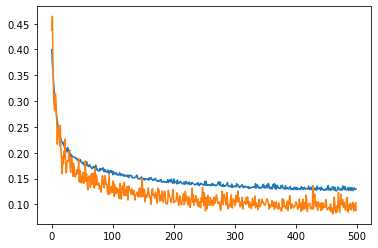

In [93]:
plt.plot(np.arange(500), train_loss)
plt.plot(np.arange(500), val_loss)

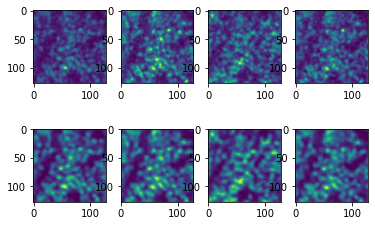

In [94]:
model.eval()
testSet = MyoDataSet(im1, 1)
testloader = testSet.get_loader(np.arange(40), 4, 0)

fig, ax = plt.subplots(2, 4)
ct = 0
batch = next(iter(testloader))
x = batch['input']
y = batch['target']
pred = model(x)
for jj in range(len(x)):
    ax[0][ct].imshow(y[jj, ...].squeeze().detach().cpu().numpy())
    ax[1][ct].imshow(pred[jj, ...].squeeze().detach().cpu().numpy())
    ct += 1

In [32]:
batch['input'].shape

torch.Size([4, 1, 128, 128])